<a href="https://colab.research.google.com/github/UtG1209/Supply-Chain-Optimization/blob/main/Product%20segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [ ]:
import pandas as pd

# Load datasets
sales = pd.read_csv('sales_train_evaluation.csv')
prices = pd.read_csv('sell_prices.csv')
calendar = pd.read_csv('calendar.csv')

# Assuming COLS_DATE is a list of columns representing daily sales data
COLS_DATE = [f'd_{i}' for i in range(1, 366)]

# Filter sales data for 'XYZ' category
df_filtered = sales[sales['cat_id'] == 'FOODS'].copy()


In [ ]:
df_filtered.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
1612,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,0,0,1,...,2,3,1,0,0,0,1,0,0,0
1613,FOODS_1_002_CA_1_evaluation,FOODS_1_002,FOODS_1,FOODS,CA_1,CA,0,1,0,1,...,2,1,0,1,1,1,0,1,1,2
1614,FOODS_1_003_CA_1_evaluation,FOODS_1_003,FOODS_1,FOODS,CA_1,CA,0,0,0,0,...,2,0,0,0,0,0,2,2,0,1
1615,FOODS_1_004_CA_1_evaluation,FOODS_1_004,FOODS_1,FOODS,CA_1,CA,0,0,0,0,...,5,6,2,5,1,2,1,1,3,4
1616,FOODS_1_005_CA_1_evaluation,FOODS_1_005,FOODS_1,FOODS,CA_1,CA,3,9,3,3,...,2,1,11,0,0,0,0,0,0,1


In [ ]:
# Group by 'item_id', 'dept_id', and 'cat_id' and sum the daily sales
df_grouped = df_filtered.groupby(['item_id', 'dept_id', 'cat_id'])[COLS_DATE].sum().reset_index()


In [ ]:
# Calculate mean and standard deviation
df_grouped['mean'] = df_grouped[COLS_DATE].mean(axis=1)
df_grouped['std'] = df_grouped[COLS_DATE].std(axis=1)

# Filter out items with zero mean (no sales)
df_grouped = df_grouped[df_grouped['mean'] > 0]


In [ ]:
df_grouped.head()

,item_id,dept_id,cat_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,...,d_359,d_360,d_361,d_362,d_363,d_364,d_365,mean,std,CV
0,FOODS_1_001,FOODS_1,FOODS,6,6,4,6,7,18,10,...,8,14,7,13,9,8,10,7.630137,6.043584,0.792068
1,FOODS_1_002,FOODS_1,FOODS,4,5,7,4,3,4,1,...,0,6,5,2,4,2,1,3.695890,2.179603,0.589737
2,FOODS_1_003,FOODS_1,FOODS,14,8,3,6,3,8,13,...,4,11,10,9,3,7,12,8.630137,4.472464,0.518238
4,FOODS_1_005,FOODS_1,FOODS,34,32,13,20,10,21,18,...,7,13,7,8,7,5,13,15.350685,12.902116,0.840491
5,FOODS_1_006,FOODS_1,FOODS,16,9,20,16,14,21,54,...,7,9,6,12,6,18,4,15.449315,8.290123,0.536601


In [ ]:
mean_prices = prices.groupby('item_id')['sell_price'].mean()

df_merged = df_grouped.merge(mean_prices, on=['item_id'], how='left').fillna({'sell_price': 0})

df_merged['turnover'] = df_merged.apply(lambda row: row[COLS_DATE] * row['sell_price'], axis=1).sum(axis=1)

In [ ]:
mean_prices



item_id
FOODS_1_001         2.166623
FOODS_1_002         8.933913
FOODS_1_003         2.975184
FOODS_1_004         1.848631
FOODS_1_005         3.329372
                     ...    
HOUSEHOLD_2_512     3.969964
HOUSEHOLD_2_513     2.780000
HOUSEHOLD_2_514    18.797089
HOUSEHOLD_2_515     1.969230
HOUSEHOLD_2_516     5.936480
Name: sell_price, Length: 3049, dtype: float64

In [ ]:
# Calculate TO%
total_turnover = df_merged['turnover'].sum()
df_merged['TO%'] = 100 * df_merged['turnover'] / total_turnover

# Sort by TO% in descending order
df_merged = df_merged.sort_values(by='TO%', ascending=False).reset_index(drop=True)


In [ ]:
# Number of SKUs
len(df_merged)

912

In [ ]:
# Calculate cumulative percentage of turnover
df_merged['TO%_CS'] = df_merged['TO%'].cumsum()

# Determine boundaries for A, B, and C categories
n_sku = len(df_merged)
n_a, n_b = int(0.05 * n_sku), int(0.5 * n_sku)

# Classify SKUs into A, B, and C categories
df_merged['ABC'] = pd.cut(df_merged.index, bins=[0, n_a, n_b, n_sku], labels=['A', 'B', 'C'])


In [ ]:
df_merged.head()

,item_id,dept_id,cat_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,...,d_363,d_364,d_365,mean,std,sell_price,turnover,TO%,TO%_CS,ABC
0,FOODS_3_586,FOODS_3,FOODS,516,479,328,376,319,430,405,...,376,462,538,535.254795,123.041574,1.595922,311792.086525,1.918966,1.918966,NaN
1,FOODS_3_587,FOODS_3,FOODS,298,353,234,310,205,214,190,...,202,168,265,280.917808,74.761664,2.515532,257930.064894,1.587465,3.506430,A
2,FOODS_3_202,FOODS_3,FOODS,106,113,65,80,75,90,98,...,90,133,184,154.575342,65.376786,4.260904,240400.218085,1.479575,4.986005,A
3,FOODS_3_555,FOODS_3,FOODS,321,315,214,204,159,265,240,...,214,263,334,319.005479,78.299720,1.595887,185820.239291,1.143655,6.129661,A
4,FOODS_3_090,FOODS_3,FOODS,1046,1036,673,642,531,877,1117,...,670,1006,993,358.498630,501.098078,1.364521,178550.338085,1.098912,7.228572,A


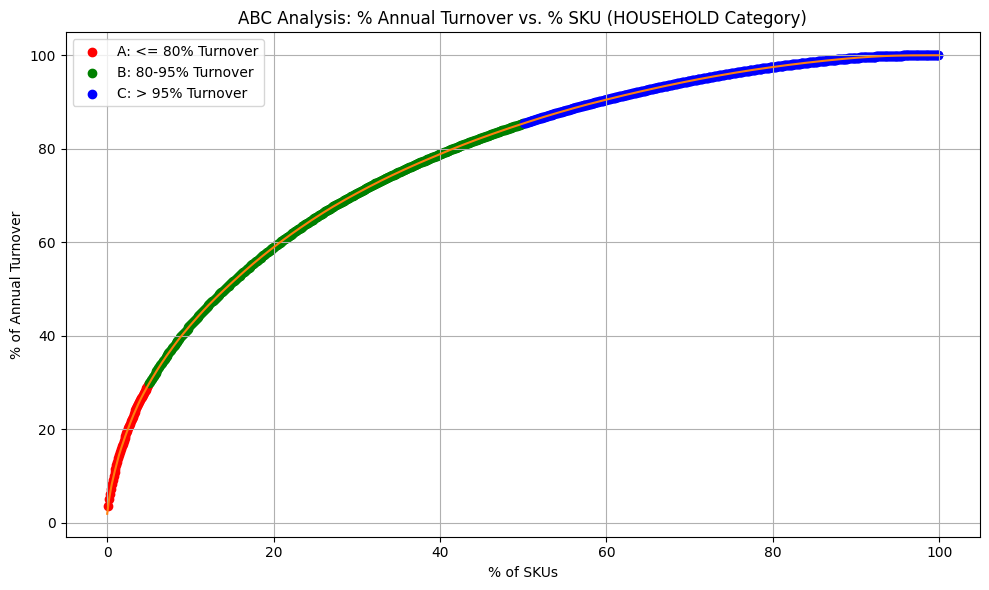

In [ ]:
import matplotlib.pyplot as plt

# Plotting the Pareto curve
plt.figure(figsize=(10, 6))

# Plot cumulative percentage of turnover vs. cumulative percentage of SKUs
plt.plot(df_merged.index / n_sku * 100, df_merged['TO%_CS'], marker='', linestyle='-', color='C1')

# Markers for A, B, and C categories
plt.scatter(df_merged[df_merged['ABC'] == 'A'].index / n_sku * 100, df_merged[df_merged['ABC'] == 'A']['TO%_CS'], color='r', label='A: <= 80% Turnover')
plt.scatter(df_merged[df_merged['ABC'] == 'B'].index / n_sku * 100, df_merged[df_merged['ABC'] == 'B']['TO%_CS'], color='g', label='B: 80-95% Turnover')
plt.scatter(df_merged[df_merged['ABC'] == 'C'].index / n_sku * 100, df_merged[df_merged['ABC'] == 'C']['TO%_CS'], color='b', label='C: > 95% Turnover')

# Plot settings
plt.title('ABC Analysis: % Annual Turnover vs. % SKU (HOUSEHOLD Category)')
plt.xlabel('% of SKUs')
plt.ylabel('% of Annual Turnover')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-67-2f7882bf814b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ABC', y='TO%', data=df_merged, palette='Set3')


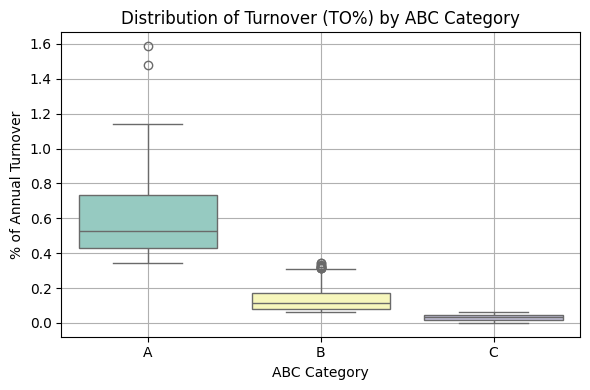

In [ ]:
# Plotting distribution of TO% by ABC category
plt.figure(figsize=(6, 4))
sns.boxplot(x='ABC', y='TO%', data=df_merged, palette='Set3')
plt.title('Distribution of Turnover (TO%) by ABC Category')
plt.xlabel('ABC Category')
plt.ylabel('% of Annual Turnover')
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-69-ae39fbb04b7d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_skus['Cumulative TO%'] = df_top_skus['TO%'].cumsum()


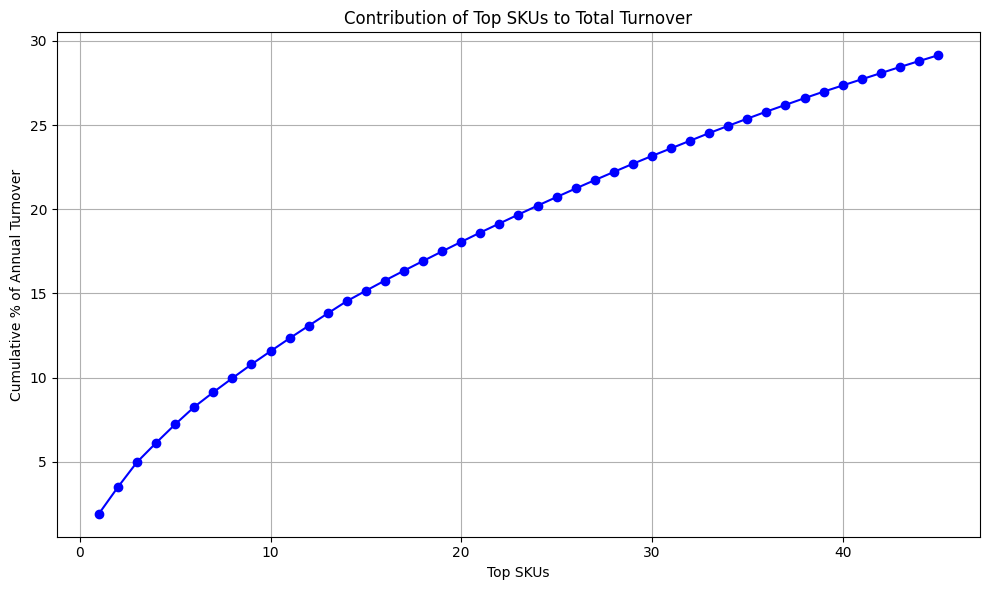

In [ ]:
# Calculate cumulative TO% for top SKUs
top_sku_count = int(0.05 * len(df_merged))  # Example: Top 20% SKUs
df_top_skus = df_merged.head(top_sku_count)
df_top_skus['Cumulative TO%'] = df_top_skus['TO%'].cumsum()

# Plotting cumulative TO% for top SKUs
plt.figure(figsize=(10, 6))
plt.plot(range(1, top_sku_count + 1), df_top_skus['Cumulative TO%'], marker='o', linestyle='-', color='b')
plt.title('Contribution of Top SKUs to Total Turnover')
plt.xlabel('Top SKUs')
plt.ylabel('Cumulative % of Annual Turnover')
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-70-360ac7561beb>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=abc_counts.index, y=abc_counts.values, palette='Set3')


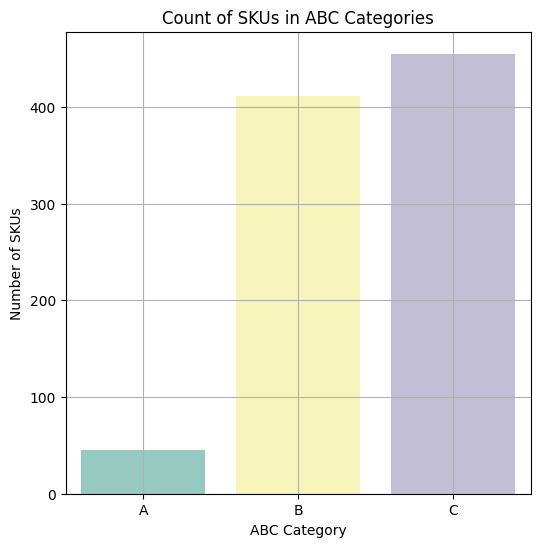

In [ ]:
# Assuming df_merged contains the DataFrame after ABC classification
# Count the number of SKUs in each ABC category
abc_counts = df_merged['ABC'].value_counts()

# Plotting the count of A, B, C categories
plt.figure(figsize=(6, 6))
sns.barplot(x=abc_counts.index, y=abc_counts.values, palette='Set3')
plt.title('Count of SKUs in ABC Categories')
plt.xlabel('ABC Category')
plt.ylabel('Number of SKUs')

plt.grid(True)
plt.show()


### DEMAND VARIABILITY

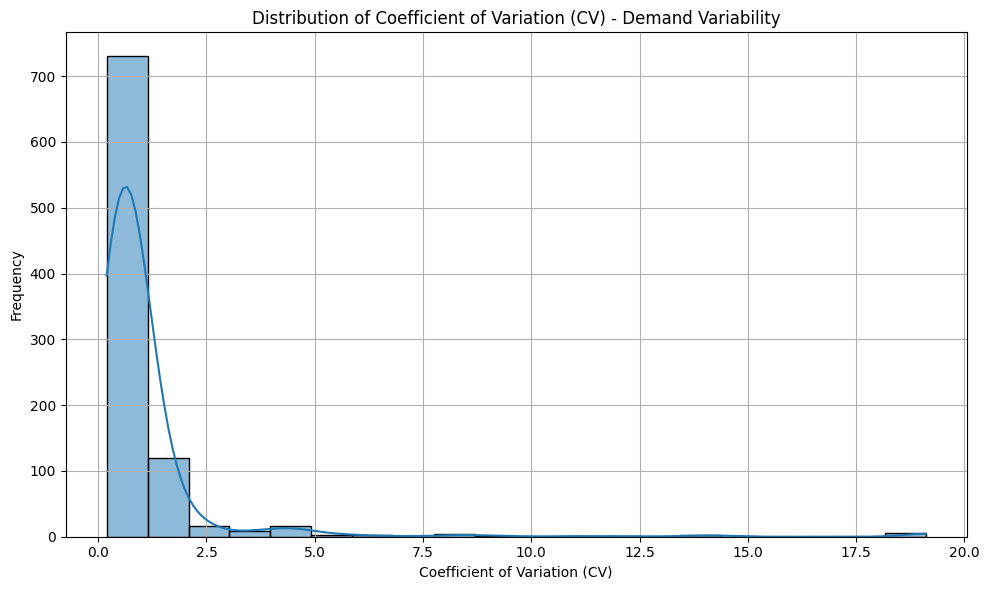

In [ ]:
df_grouped['CV'] = df_grouped['std'] / df_grouped['mean']

# Plotting demand variability (CV)
plt.figure(figsize=(10  , 6))
sns.histplot(df_grouped['CV'], bins=20, kde=True)
plt.title('Distribution of Coefficient of Variation (CV) - Demand Variability')
plt.xlabel('Coefficient of Variation (CV)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

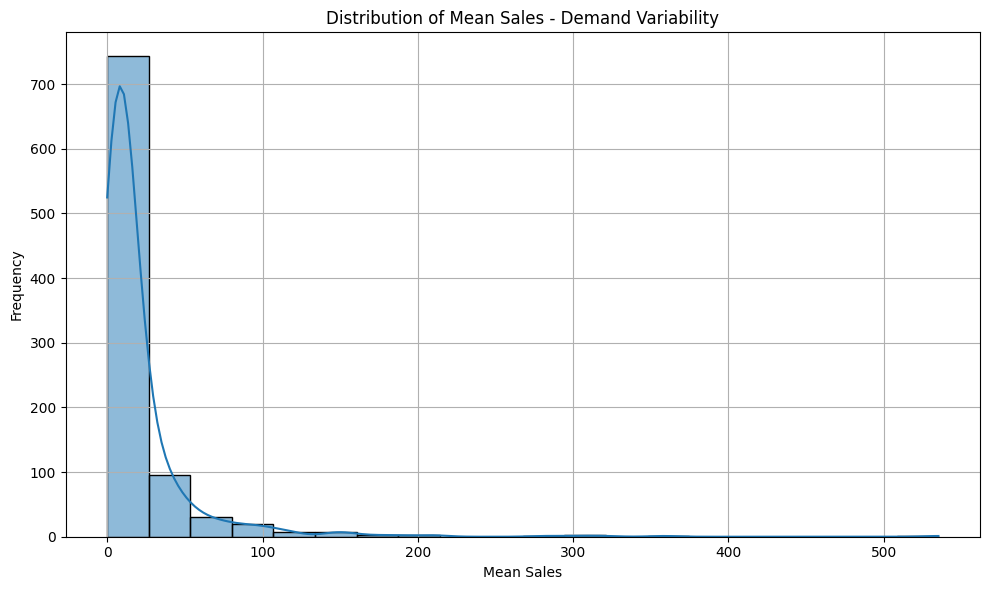

In [ ]:
# Plotting distribution of mean sales
plt.figure(figsize=(10, 6))
sns.histplot(df_grouped['mean'], bins=20, kde=True)
plt.title('Distribution of Mean Sales - Demand Variability')
plt.xlabel('Mean Sales')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


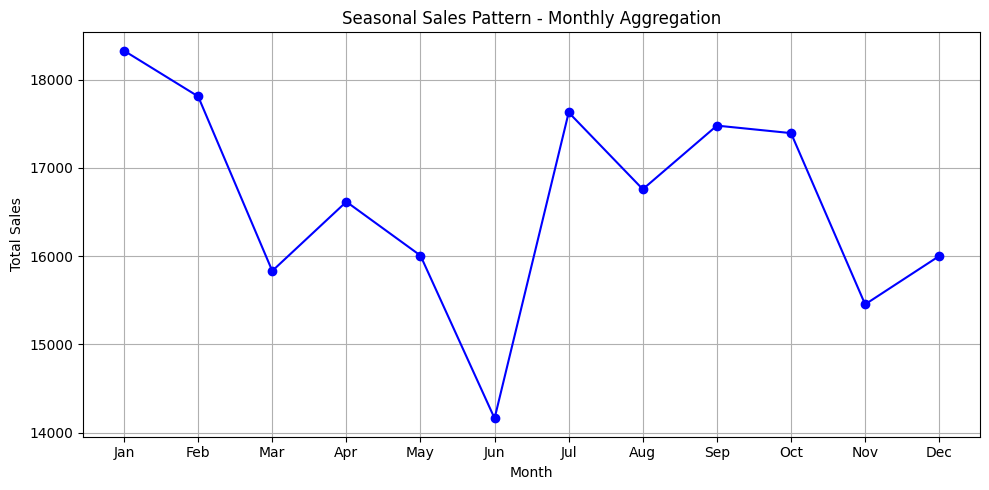

In [ ]:
# Example: Creating a dataframe with day numbers and daily sales data
days_in_year = np.arange(1, 367)  # Assuming you have days 1 to 366
np.random.seed(0)
sales_data = np.random.randint(100, 1000, 366)  # Example of daily sales data
df_filtered = pd.DataFrame({'day': days_in_year, 'sales': sales_data})

# Aggregate sales data by month
df_filtered['month'] = np.ceil(df_filtered['day'] / 30).astype(int)
df_monthly_sales = df_filtered.groupby('month')['sales'].sum()

# Plotting seasonal sales pattern month-wise
plt.figure(figsize=(10, 5))
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.plot(months[:12], df_monthly_sales.values[:12], marker='o', linestyle='-', color='b')
plt.title('Seasonal Sales Pattern - Monthly Aggregation')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

### NORMALITY TEST





In [ ]:
from scipy.stats import shapiro

Shapiro-Wilk Test - Statistic: 0.9926937818527222, p-value: 0.8689165711402893
Turnover data looks Gaussian (fail to reject H0)


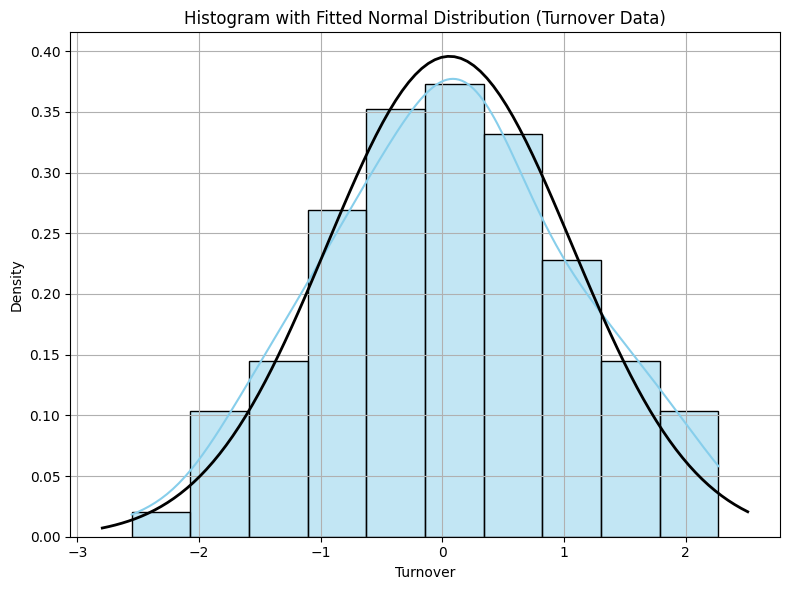

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
import numpy as np

np.random.seed(0)
turnover_data = df_merged['turnover'].copy()
turnover_data = np.random.normal(loc=0, scale=1, size=100)  # Replace with df_abc['TO'] or actual turnover data

# Performing Shapiro-Wilk test for normality
statistic, p_value = shapiro(turnover_data)
alpha = 0.05
print(f'Shapiro-Wilk Test - Statistic: {statistic}, p-value: {p_value}')
if p_value > alpha:
    print('Turnover data looks Gaussian (fail to reject H0)')
else:
    print('Turnover data does not look Gaussian (reject H0)')

# Plotting histogram with fitted normal curve
plt.figure(figsize=(8, 6))
sns.histplot(turnover_data, bins=10, kde=True, stat='density', color='skyblue', edgecolor='black')

# Overlaying normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-0.5 * ((x - np.mean(turnover_data)) / np.std(turnover_data))**2) / (np.sqrt(2 * np.pi) * np.std(turnover_data))
plt.plot(x, p, 'k', linewidth=2)

plt.title('Histogram with Fitted Normal Distribution (Turnover Data)')
plt.xlabel('Turnover')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()


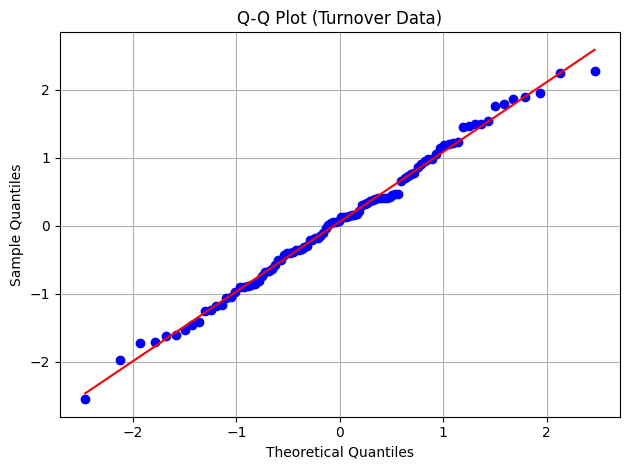

In [ ]:
# Plotting Q-Q plot
stats.probplot(turnover_data, dist="norm", plot=plt)
plt.title('Q-Q Plot (Turnover Data)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# prompt: concat the CV column of df_grouped to df_merged

df_merged = df_merged.join(df_grouped['CV'])


In [ ]:
df_merged.head()

,item_id,dept_id,cat_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,...,d_364,d_365,mean,std,sell_price,turnover,TO%,TO%_CS,ABC,CV
0,FOODS_3_586,FOODS_3,FOODS,516,479,328,376,319,430,405,...,462,538,535.254795,123.041574,1.595922,311792.086525,1.918966,1.918966,NaN,0.792068
1,FOODS_3_587,FOODS_3,FOODS,298,353,234,310,205,214,190,...,168,265,280.917808,74.761664,2.515532,257930.064894,1.587465,3.506430,A,0.589737
2,FOODS_3_202,FOODS_3,FOODS,106,113,65,80,75,90,98,...,133,184,154.575342,65.376786,4.260904,240400.218085,1.479575,4.986005,A,0.518238
3,FOODS_3_555,FOODS_3,FOODS,321,315,214,204,159,265,240,...,263,334,319.005479,78.299720,1.595887,185820.239291,1.143655,6.129661,A,NaN
4,FOODS_3_090,FOODS_3,FOODS,1046,1036,673,642,531,877,1117,...,1006,993,358.498630,501.098078,1.364521,178550.338085,1.098912,7.228572,A,0.840491


In [ ]:
df_merged.to_csv('df_merged.csv', index=False)